In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import os
import torch.nn as nn
import torchvision.transforms.functional as Fvis
import torch.nn.functional as F
from torch.autograd import Variable
import datetime
from dataset import *
n_classes = len(diagnos.keys())

Current folder:/raid/anagashbayev/3D-Capsule-for-AD/
Data folder:/raid/anagashbayev/
SUBJECT_INDEPENDENT: True
use_whole_data False
use ALL copies of same subject False
test/train imgs per subject 4/4


Number of SUBJECTS in each group of dataset	 {'AD': 89, 'MCI': 212, 'CN': 161} in TOTAL  462
Number of IMAGES in each group of dataset	 {'AD': 193, 'MCI': 909, 'CN': 442} in TOTAL  1544


Number of USED SUBJECTS in each group		 {'AD': 89, 'CN': 89} in TOTAL  178
Number of USED IMAGES in each group 		 {'AD': 185, 'CN': 222} in TOTAL  407


Number of SUBJECTS in each group of TEST split	 {'AD': 19, 'CN': 19} in TOTAL  38
Number of SUBJECTS in each group of TRAIN split	 {'AD': 70, 'CN': 70} in TOTAL  140


Number of IMAGES in each group of TEST split	 {'AD': 44, 'CN': 48} in TOTAL  92
Number of IMAGES in each group of TRAIN split	 {'AD': 141, 'CN': 174} in TOTAL  315


In [2]:
# mnist_path = os.getcwd().split("3D")[0]
# del mnist_path

In [3]:
batch_size =10

In [4]:
# trainset = torchvision.datasets.MNIST(mnist_path,train=True,transform=Fvis.to_tensor)
# testset = torchvision.datasets.MNIST(mnist_path,train=False,transform=Fvis.to_tensor)
# # cifar_trainset = torchvision.datasets.CIFAR10(os.getcwd(),download=True,train=True,transform=Fvis.to_tensor)
# # cifar_testset = torchvision.datasets.CIFAR10(os.getcwd(),download=True,train=False,transform=Fvis.to_tensor)
# train_loader = torch.utils.data.DataLoader(
#     dataset=trainset,
#     batch_size=batch_size,
#     drop_last=True,

#     shuffle=True,)
# test_loader = torch.utils.data.DataLoader(
#                 dataset=testset,
#                 batch_size=batch_size,
#                 drop_last=True,
#                 shuffle=False)

torch.Size([128, 1, 28, 28])
1


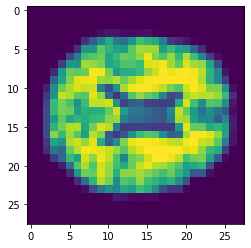

In [6]:
for i in train_loader:
#     if 'mnist_path' in locals():
#         print(mnist_path)
#         mnist_shape = i[0].shape #1, 28, 28
    mnist_shape = (28, 28)
#     print(mnist_shape)
    print(i[0].shape)
    plt.imshow(i[0][0,0])
    in_channels_of_input = i[0].shape[1]
    print(in_channels_of_input)
    break

In [7]:
class ConvLayer(nn.Module):
    def __init__(self,in_ch=in_channels_of_input,out_ch=256,kernel_size=9,stride=1):
        super(ConvLayer,self).__init__()
        self.conv1 = torch.nn.Conv2d(in_ch,out_ch,kernel_size,stride)
    def squash(self,x):
        norms = torch.norm(x,dim=1,keepdim=True)
        x = ((norms/(1+norms**2))*x)
        return x
    def forward(self,x):

#         print(x.shape)
        x = self.squash(self.conv1(x))
        return x
    
class PrimaryCapsules(nn.Module):
    def __init__(self,in_ch=256,out_caps_grids=32,out_ch_of_each_caps=8,kernel_size=9,stride=2):
        super(PrimaryCapsules,self).__init__()
        self.out_caps_grids=out_caps_grids
        self.out_ch_of_each_caps=out_ch_of_each_caps
        self.prim_caps = torch.nn.Conv2d(in_ch,out_caps_grids*out_ch_of_each_caps,kernel_size,stride)
    def reshape(self,x):
        b,d1,d2,d3=x.shape
        x=x.permute(0,2,3,1)
        x=x.reshape(b,d2,d3,self.out_caps_grids,self.out_ch_of_each_caps)
        return x
    def squash(self,x):
        norms = torch.norm(x,dim=-1,keepdim=True)
        x = ((norms/(1+norms**2))*x)
        return x
    def forward(self,x):
        return self.squash(self.reshape(self.prim_caps(x)))
    
class DigitCaps(nn.Module):
    def __init__(self,input_grid=( 6, 6, 32),in_cap_dim=8,out_cap_dim=16,out_caps=n_classes):
        super(DigitCaps,self).__init__()
        self.in_cap_dim=in_cap_dim
        self.num_caps = 1
        
        for i in input_grid:
            self.num_caps*=i
        self.W = torch.nn.Parameter(torch.randn(1, out_caps, self.num_caps, out_cap_dim, in_cap_dim))
        self.b = torch.nn.Parameter(torch.zeros(1, out_caps, self.num_caps,1,1),requires_grad=False)
    def reshape(self,x):
        batch_size=x.shape[0]
        x=x.reshape(batch_size,1,-1,self.in_cap_dim,1)
        return x
    def squash(self,x):
        norms = torch.norm(x,dim=-1,keepdim=True)
        x = ((norms/(1+norms**2))*x)
        return x
    def forward(self,x):
        batch_size=x.shape[0]
#         print('x',x.shape)
        u = self.reshape(x)
#         print('w',self.W.shape)
#         print('u',u.shape)
        
        uhat = torch.matmul(self.W,u)
#         print('uhat',uhat.shape)
        b = self.b
        for i in range(3):
#             print('iter ',i)
#             print('b',self.b.shape)
            c = torch.softmax(b,dim=2)
#             print('c',c.shape)
#             print(c.sum())
#             try:
            ahat= (uhat*c)
#             except:
#                 print('b',self.b.shape)

#                 print('uhat',uhat.shape)
#                 print('c',c.shape)

#             print('ahat',ahat.shape)
            a=ahat.sum(dim=2,keepdim=True).permute(0,1,2,4,3)
#             print('a',a.shape)
#             print('uhat',uhat.shape)

            adotuhat= torch.matmul(a,uhat).mean(dim=0,keepdim=True)
#             print('adotuhat.shape',adotuhat.shape)
#             print('b.shape',b.shape)
            b = b+adotuhat
            if self.training:
                self.b=torch.nn.Parameter(b,requires_grad=False)
        x = self.squash(a)
        return x



In [8]:
model1 = ConvLayer()
model2 = PrimaryCapsules()
model3 = DigitCaps()
for batch_id, (data, target) in enumerate(train_loader,1):
    print(data.shape)
    data = model1(data)
    print(data.shape)
    data = model2(data)
    print(data.shape)
    data = model3(data)
    print(data.shape)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128, 256, 20, 20])
torch.Size([128, 6, 6, 32, 8])
torch.Size([128, 2, 1, 1, 16])


In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.l1=ConvLayer()
        self.l2=PrimaryCapsules()
        self.l3=DigitCaps()
    
    def forward(self,x):
#         print("before enc",x.shape)
        batch_size = x.shape[0]
        x= self.l1(x)
#         print('x.shape',x.shape)
        
#         print(x.shape)
        x=self.l2(x)
#         print('x.shape',x.shape)
    
#         print(x.shape)
        x=self.l3(x)
#         print('x.shape',x.shape)
#         print(x.shape)
        
#         print(output.shape)
#         x = x.squeeze()
        x=x.reshape(x.shape[0],x.shape[1],x.shape[-1])
#         print('x.shape',x.shape)

        return x


In [10]:
class Decoder(nn.Module):
    def __init__(self,l0=16,l1=512,l2=1024,l3=784):
        super(Decoder,self).__init__()
        self.fc1=nn.Linear(l0,l1)
        self.fc2=nn.Linear(l1,l2)
        self.fc3=nn.Linear(l2,l3)

    def forward(self,x):
#         print(x.shape)
        x = self.fc1(x)
#         print(x.shape)
        x=F.relu(x)
        x = self.fc2(x)
        x=F.relu(x)
#         print(x.shape)
        x=self.fc3(x)
        x=torch.sigmoid(x)
#         print(x.shape)
        return x


In [11]:
class CapsNet3D(nn.Module):
    def __init__(self):
        super(CapsNet3D,self).__init__()
        self.enc = Encoder()
        self.dec = Decoder()
        self.encloss=nn.CrossEntropyLoss()
    def margin_loss(self,pred_prob,target):

#         print('pred_prob.shape',pred_prob.shape)
#         print('pred_prob[:5]',pred_prob[:5])
#         print('target.shape',target.shape)
#         print('target[:5]',target[:5])
        
        _, max_length_indices = pred_prob.max(dim=1)
#         print('_.shape',_.shape)
#         print('_[:5]',_[:5])
#         print('max_length_indices.shape',max_length_indices.shape)
#         print('max_length_indices[:5]',max_length_indices[:5])
        masked= Variable(torch.sparse.torch.eye(n_classes),requires_grad=False)
#         masked = torch.eye(n_classes)
        if USE_CUDA:
            masked=masked.cuda()
        
#         print('masked.shape',masked.shape)
#         print('masked',masked)
#         masked = masked.index_select(dim=0, index=max_length_indices.data)
        masked = masked.index_select(dim=0, index=target)

        Tk = masked
#         print("Tk.shape",Tk.shape)
#         print("Tk[0:5]",Tk[0:5])
        left = Tk*F.relu(0.9-pred_prob)**2
#         print('left.shape',left.shape)
        right = 0.5*(1-Tk)*F.relu(pred_prob-0.1)**2
#         print('right.shape',right.shape)
        total =(left+right).sum()
#         print('total.shape',total.shape)
        return total
    def loss(self,pred_prob,target_class,target_recon=None,decout=None):
#         if target_recon.shape!=decout.shape:
#             target_recon = F.adaptive_avg_pool2d(target_recon,mnist_shape)

#         pred_prob =torch.norm(encout,dim=-1,keepdim=False)
#         encoder_loss = self.encloss(pred_prob,target_class)
#         print(target_class[0])
#         print(pred_prob[0])
        margin = self.margin_loss(pred_prob,target_class)
        decoder_loss = ((target_recon-decout)**2).sum()
#         total = margin
#         total = encoder_loss,margin
#         print(total, typeof)
#         return encoder_loss,decoder_loss
        return margin,decoder_loss
    
    def fetch(self,encout):
#         print('fetching')
#         print('encout.shape',encout.shape)
#         if len(encout.shape)==1:
#             encout = encout.unsqueeze(0)
        pred_prob =torch.norm(encout,dim=-1,keepdim=False)#.squeeze()
#         print('prob',pred_prob.shape)

        _, max_length_indices = pred_prob.max(dim=1)
#         print('_.shape',_.shape)
#         print('_[:10]',_[:10])
#         print('max_length_indices.shape',max_length_indices.shape)
#         print('max_length_indices[:10]',max_length_indices[:10])
        masked= Variable(torch.sparse.torch.eye(n_classes),requires_grad=False)

#         masked = torch.sparse.torch.eye(n_classes)
        if USE_CUDA:
            masked=masked.cuda()
        
#         print('masked.shape',masked.shape)
#         print('masked',masked)
        masked = masked.index_select(dim=0, index=max_length_indices.data)
#         print('masked.shape',masked.shape)
#         print('masked',masked)
#         print('encout.shape',encout.shape)

        decin =torch.matmul(masked[:, None,:],encout).view(encout.size(0), -1)
#         print('decin',decin)
#         print('decin.shape',decin.shape)
#         print(decin[0,:])
#         print(encout[0,max_length_indices[0],:])
        return pred_prob,decin
        
    def forward(self,x):
        encout=self.enc(x)
        pred_prob,decin=self.fetch(encout)
#         print(decin.shape)
        decout=self.dec(decin).reshape(-1,1,28,28)
#         print(decout.shape)
        return pred_prob,decout


In [12]:
caps=CapsNet3D().cuda()
# model =caps

In [13]:
loss_fn=caps.loss
model = nn.DataParallel(caps)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)


In [14]:
print(model)

DataParallel(
  (module): CapsNet3D(
    (enc): Encoder(
      (l1): ConvLayer(
        (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
      )
      (l2): PrimaryCapsules(
        (prim_caps): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
      )
      (l3): DigitCaps()
    )
    (dec): Decoder(
      (fc1): Linear(in_features=16, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=1024, bias=True)
      (fc3): Linear(in_features=1024, out_features=784, bias=True)
    )
    (encloss): CrossEntropyLoss()
  )
)


In [15]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

6962192

In [18]:
k1=1
k2=1/batch_size
USE_CUDA=True
n_epochs = 100
start = 0
l = 3
train_loss_accuracy_hist=np.zeros((l,n_epochs))
test_loss_accuracy_hist=np.zeros((l,n_epochs))
ltr= len(train_loader)
lts= len(test_loader)
for epoch in range(start,start+n_epochs):
    print('epoch/n_epochs',epoch,'/',n_epochs)
    model.train()
    train_loss_enc = 0
    train_loss_dec = 0
    train_pred = np.empty((batch_size), int)
    train_targets = np.empty((batch_size), int)
    test_targets = np.empty((batch_size), int)
    test_pred =  np.empty((batch_size), int)
    for batch_id, (data, target) in enumerate(train_loader,1):
#         target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        print(batch_id,'/',ltr,end='\r')
    
        data, target = Variable(data), Variable(target)
#         data, target = Variable(data), Variable(target)
        if USE_CUDA:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
#         pred_prob = model(data)
        pred_prob,dec = model(data)

        loss1,loss2=loss_fn(pred_prob,target,data,dec)
#         loss=loss_fn(pred_prob,target,data,None)
#         loss1,loss2=loss_fn(pred_prob,target)
#         print(loss1.item(),loss2.item())
#         loss = loss1#+loss2
        loss1,loss2 = k1*loss1,k2*loss2 
        loss = loss1+loss2
        loss.backward()
        optimizer.step()
        train_loss_enc += loss1.item()
        train_loss_dec += loss2.item()
#         print(output.shape)
        train_pred = np.append(train_pred, np.argmax(pred_prob.data.cpu().numpy(), 1), axis=0)
        train_targets = np.append(train_targets, target.cpu(), axis=0)
#         print(pre1,pre2)
#         if batch_id % 1 == 0:
#             print('epoch',epoch, 'batch_id',batch_id,"train accuracy:", sum(train_pred[batch_size:] == train_targets[batch_size:]) / len(train_pred[batch_size:]),end='\r')
#         if batch_id == 1:
#             break
    train_targets=train_targets[batch_size:]
    train_pred=train_pred[batch_size:]
    train_loss_accuracy_hist[:,epoch]=[train_loss_enc/ len(train_loader),train_loss_dec / len(train_loader),sum(train_pred == train_targets) / len(train_pred)]

    
    print ('\ntrain loss enc',train_loss_accuracy_hist[0,epoch],'train loss dec',train_loss_accuracy_hist[1,epoch],'\ntrain accuracy',train_loss_accuracy_hist[-1,epoch],"\n")
#     if epoch == 0:
#         break

    model.eval()
    test_loss_enc = 0
    test_loss_dec = 0
    inxHistTest=[]
    for batch_id, (data, target) in enumerate(test_loader,1):
#         target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        print('\t\t\t',batch_id,'/',lts,end='\r')

        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()
#         pred_prob = model(data)
        pred_prob,dec = model(data)
#         loss=loss_fn(target,pred_prob,data,None)
        loss1,loss2=loss_fn(pred_prob,target,data,dec)
#         print(loss1.item(),loss2.item())
        loss1,loss2 = k1*loss1,k2*loss2
#         loss=loss_fn(pred_prob,target,data,dec)
        loss = loss1+loss2
#         loss = loss2

        test_loss_enc += loss1.item()
        test_loss_dec += loss2.item()

#         print(test_pred.shape)
        test_pred = np.append(test_pred, np.argmax(pred_prob.data.cpu().numpy(), 1), axis=0)
#         print('test_pred',test_pred)
#         test_targets = np.append(test_targets, np.argmax(target.data.cpu().numpy(), 1), axis=0)
        test_targets = np.append(test_targets, target.cpu(), axis=0)
#         print('test_targets',test_targets)
#         if batch_id % 1 == 0:
#             print ("\t\t\t",'epoch',epoch, 'batch_id',batch_id,"test accuracy:", sum(test_pred[batch_size:] == test_targets[batch_size:]) / len(test_pred[batch_size:]),end='\r')
#         if batch_id % 3 == 0:
#             break
    test_targets=test_targets[batch_size:]
    test_pred=test_pred[batch_size:]
    test_loss_accuracy_hist[:,epoch]=[test_loss_enc/ len(test_loader),test_loss_dec / len(test_loader),sum(test_pred == test_targets) / len(test_pred)]
#     print('test_targets',test_targets,'test_pred',test_pred)
    print ('\n\t\t\ttest loss enc',test_loss_accuracy_hist[0,epoch],'test loss dec',test_loss_accuracy_hist[1,epoch],'\n\t\t\ttest accuracy',test_loss_accuracy_hist[-1,epoch],"\n")
#     if epoch==1:
#         break

epoch/n_epochs 0 / 100
3 / 3
train loss enc 20.53082275390625 train loss dec 57.49395243326823 
train accuracy 0.6793650793650794 

			 1 / 1
			test loss enc 18.169239044189453 test loss dec 55.7038459777832 
			test accuracy 0.6304347826086957 

epoch/n_epochs 1 / 100
3 / 3
train loss enc 20.607935587565105 train loss dec 58.080186208089195 
train accuracy 0.6761904761904762 

			 1 / 1
			test loss enc 18.134143829345703 test loss dec 55.133583068847656 
			test accuracy 0.6521739130434783 

epoch/n_epochs 2 / 100
3 / 3
train loss enc 20.412673314412434 train loss dec 57.94348462422689 
train accuracy 0.6761904761904762 

			 1 / 1
			test loss enc 18.256366729736328 test loss dec 57.36589431762695 
			test accuracy 0.6304347826086957 

epoch/n_epochs 3 / 100
3 / 3
train loss enc 20.554586092631023 train loss dec 58.4876906077067 
train accuracy 0.6793650793650794 

			 1 / 1
			test loss enc 18.034900665283203 test loss dec 55.75703811645508 
			test accuracy 0.6739130434782609 

e

3 / 3
train loss enc 18.360931396484375 train loss dec 52.62384033203125 
train accuracy 0.7206349206349206 

			 1 / 1
			test loss enc 17.722299575805664 test loss dec 53.57219314575195 
			test accuracy 0.6630434782608695 

epoch/n_epochs 34 / 100
3 / 3
train loss enc 18.265297571818035 train loss dec 52.574974060058594 
train accuracy 0.7206349206349206 

			 1 / 1
			test loss enc 17.838069915771484 test loss dec 53.671234130859375 
			test accuracy 0.6304347826086957 

epoch/n_epochs 35 / 100
3 / 3
train loss enc 18.117929140726726 train loss dec 52.23923937479655 
train accuracy 0.726984126984127 

			 1 / 1
			test loss enc 17.582660675048828 test loss dec 53.494686126708984 
			test accuracy 0.6847826086956522 

epoch/n_epochs 36 / 100
3 / 3
train loss enc 18.03053156534831 train loss dec 51.93910280863444 
train accuracy 0.7301587301587301 

			 1 / 1
			test loss enc 17.96088409423828 test loss dec 53.48843002319336 
			test accuracy 0.6086956521739131 

epoch/n_epochs 37 / 

3 / 3
train loss enc 13.857009887695312 train loss dec 47.7005500793457 
train accuracy 0.834920634920635 

			 1 / 1
			test loss enc 16.672258377075195 test loss dec 54.63850021362305 
			test accuracy 0.6521739130434783 

epoch/n_epochs 67 / 100
3 / 3
train loss enc 14.00813881556193 train loss dec 47.87986946105957 
train accuracy 0.834920634920635 

			 1 / 1
			test loss enc 19.654577255249023 test loss dec 54.9167366027832 
			test accuracy 0.5978260869565217 

epoch/n_epochs 68 / 100
3 / 3
train loss enc 13.813848177591959 train loss dec 48.1066780090332 
train accuracy 0.8476190476190476 

			 1 / 1
			test loss enc 16.573593139648438 test loss dec 55.41229248046875 
			test accuracy 0.6630434782608695 

epoch/n_epochs 69 / 100
3 / 3
train loss enc 13.541204770406088 train loss dec 48.19470024108887 
train accuracy 0.819047619047619 

			 1 / 1
			test loss enc 19.449743270874023 test loss dec 55.09897994995117 
			test accuracy 0.5869565217391305 

epoch/n_epochs 70 / 100
3 /

3 / 3
train loss enc 8.338574568430582 train loss dec 41.60144551595052 
train accuracy 0.9206349206349206 

			 1 / 1
			test loss enc 19.251144409179688 test loss dec 55.862579345703125 
			test accuracy 0.5760869565217391 



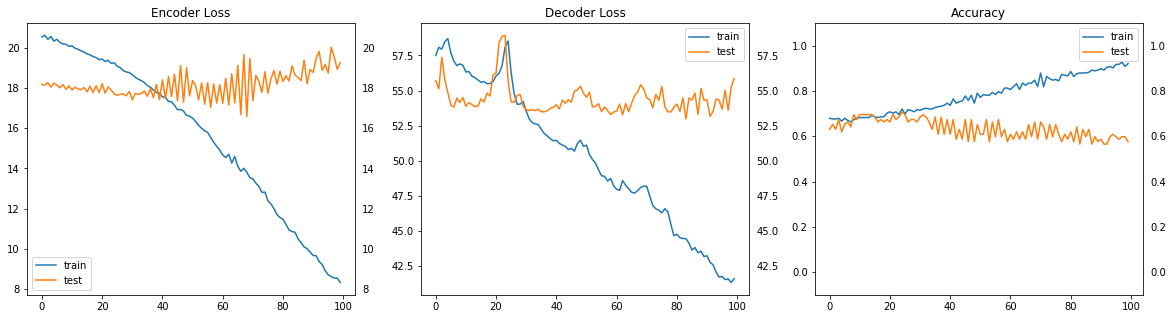

results/2020-2-11-20-33-results-mnist.png
Max Accuracy 0.7065217391304348


In [19]:
plt.figure(figsize=(20,5))
# n_epochs=100
rang = list(range(n_epochs))

plt.subplot(131)
# plt.ylim(-0.1, 1.1)
# plt.xlim(0,1.1)
plt.plot(rang,train_loss_accuracy_hist[0,:n_epochs],label='train')
plt.plot(rang,test_loss_accuracy_hist[0,:n_epochs],label='test')
plt.tick_params(axis='y', which='both', labelleft='on', labelright='on')

plt.title("Encoder Loss")
plt.legend()

plt.subplot(132)
# plt.ylim(-0.1, 1.1)
# plt.xlim(0,1.1)
plt.plot(rang,train_loss_accuracy_hist[1,:n_epochs],label='train')
plt.plot(rang,test_loss_accuracy_hist[1,:n_epochs],label='test')
plt.title("Decoder Loss")
plt.tick_params(axis='y', which='both', labelleft='on', labelright='on')

plt.legend()

plt.subplot(133)
plt.ylim(-0.1, 1.1)
# plt.xlim(0,1)
plt.plot(rang,train_loss_accuracy_hist[-1,:n_epochs],label='train')
plt.plot(rang,test_loss_accuracy_hist[-1,:n_epochs],label='test')
plt.tick_params(axis='y', which='both', labelleft='on', labelright='on')
plt.title("Accuracy")
plt.legend()
now = datetime.datetime.now()
fname= f"results/{now.year}-{now.month}-{now.day}-{now.hour}-{now.minute}-results-mnist.png"
# plt.savefig(fname)
plt.show()
print(fname)
print("Max Accuracy",test_loss_accuracy_hist[-1,:n_epochs].max())

In [20]:
# info =str(model)+'\n'+str(optimizer)
# file = open(f"results/{now.year}-{now.month}-{now.day}-{now.hour}-{now.minute}-{params}-info-mnist.txt","w+")
# file.write(info)
# file.close()

tensor(False, device='cuda:0')
target  1  prediction  0


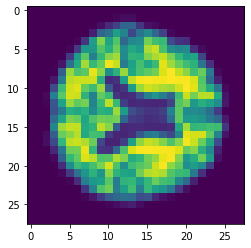

(92, 1, 28, 28)


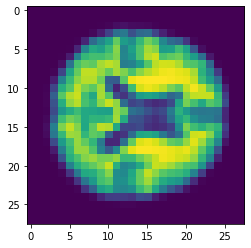

tensor(False, device='cuda:0')
target  0  prediction  1


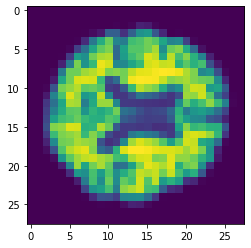

(92, 1, 28, 28)


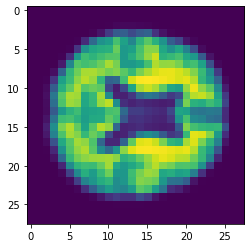

tensor(False, device='cuda:0')
target  0  prediction  1


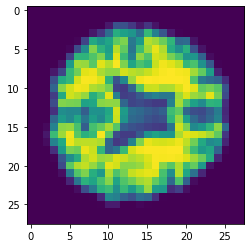

(92, 1, 28, 28)


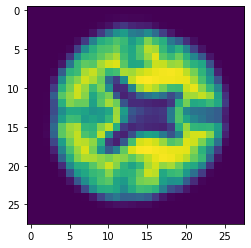

tensor(False, device='cuda:0')
target  1  prediction  0


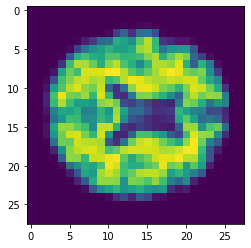

(92, 1, 28, 28)


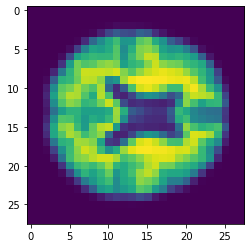

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  1  prediction  0


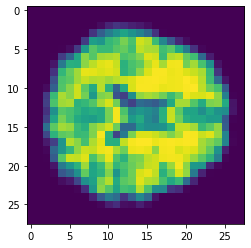

(92, 1, 28, 28)


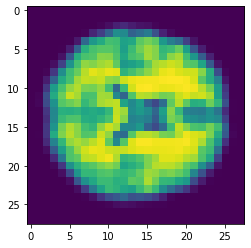

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


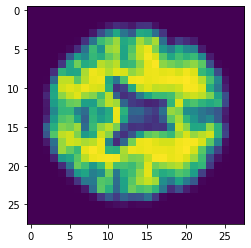

(92, 1, 28, 28)


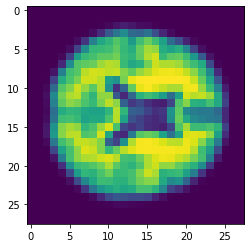

tensor(False, device='cuda:0')
target  1  prediction  0


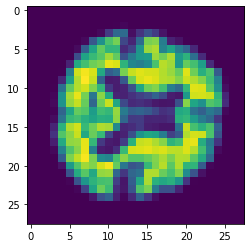

(92, 1, 28, 28)


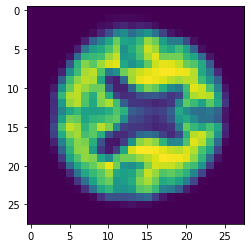

tensor(False, device='cuda:0')
target  1  prediction  0


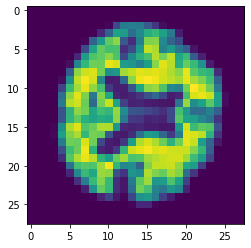

(92, 1, 28, 28)


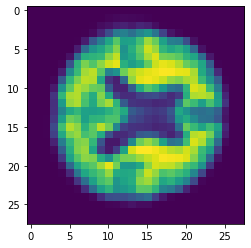

tensor(False, device='cuda:0')
target  0  prediction  1


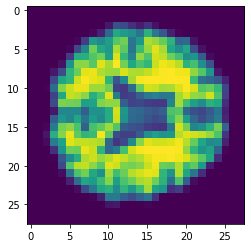

(92, 1, 28, 28)


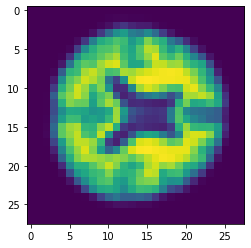

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


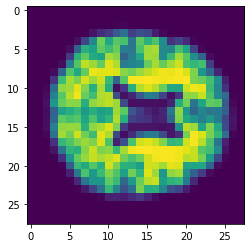

(92, 1, 28, 28)


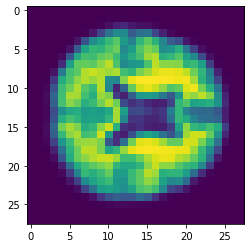

tensor(False, device='cuda:0')
target  1  prediction  0


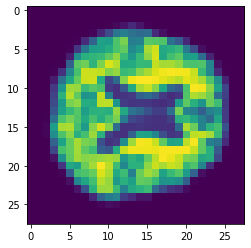

(92, 1, 28, 28)


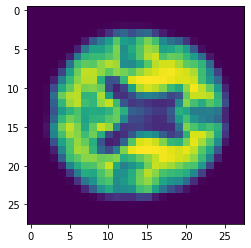

tensor(False, device='cuda:0')
target  0  prediction  1


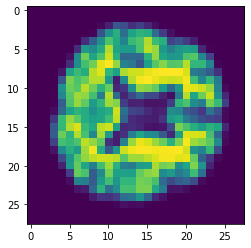

(92, 1, 28, 28)


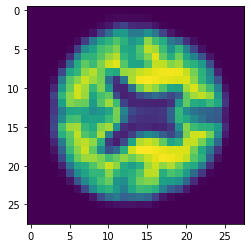

tensor(False, device='cuda:0')
target  0  prediction  1


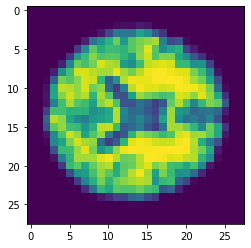

(92, 1, 28, 28)


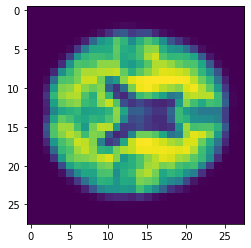

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  1  prediction  0


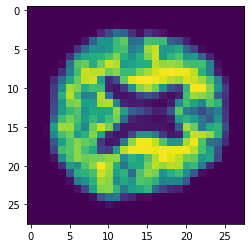

(92, 1, 28, 28)


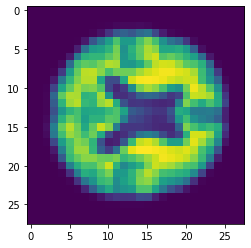

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


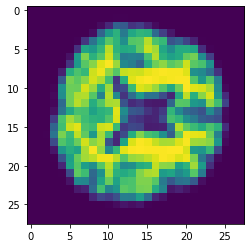

(92, 1, 28, 28)


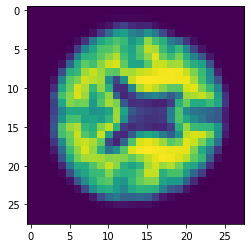

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


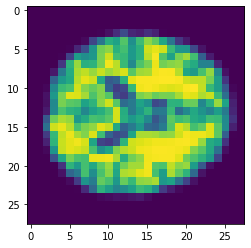

(92, 1, 28, 28)


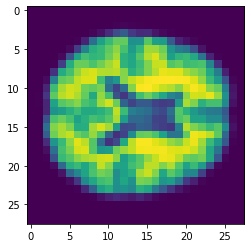

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


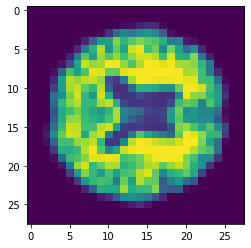

(92, 1, 28, 28)


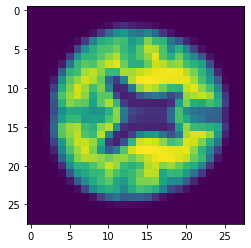

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  1  prediction  0


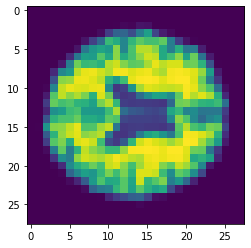

(92, 1, 28, 28)


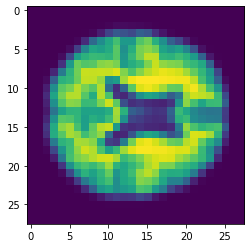

tensor(False, device='cuda:0')
target  0  prediction  1


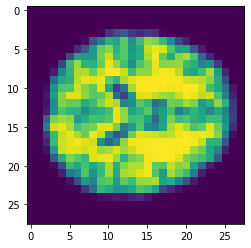

(92, 1, 28, 28)


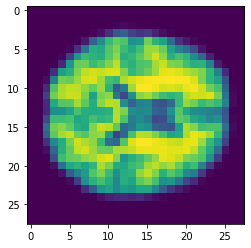

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


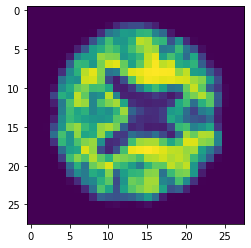

(92, 1, 28, 28)


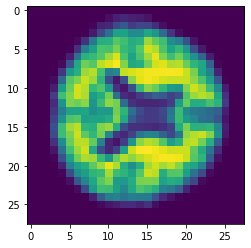

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


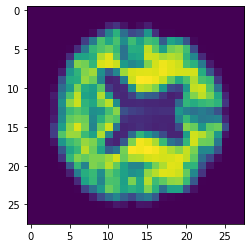

(92, 1, 28, 28)


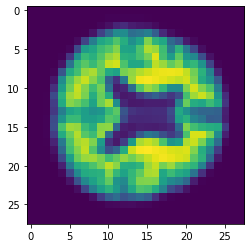

tensor(False, device='cuda:0')
target  0  prediction  1


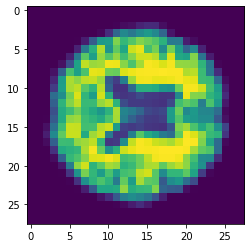

(92, 1, 28, 28)


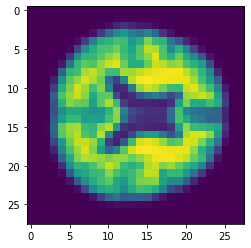

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


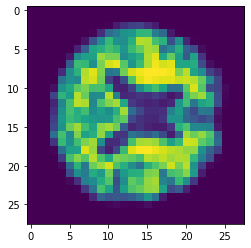

(92, 1, 28, 28)


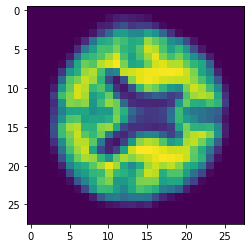

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


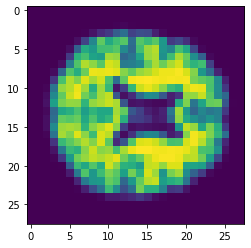

(92, 1, 28, 28)


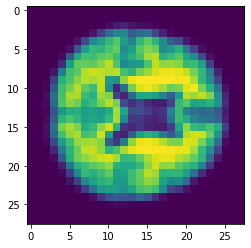

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  1  prediction  0


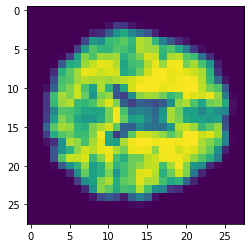

(92, 1, 28, 28)


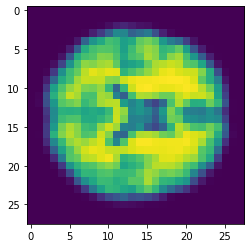

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


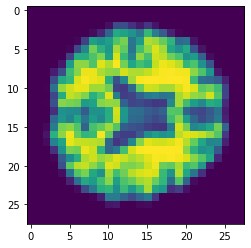

(92, 1, 28, 28)


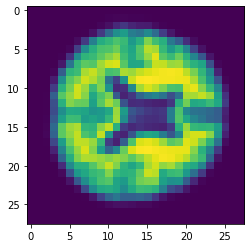

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


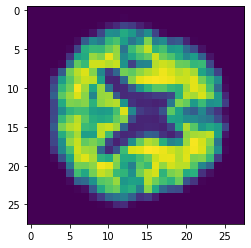

(92, 1, 28, 28)


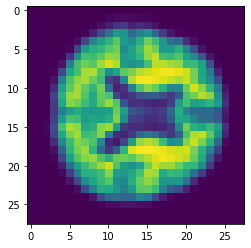

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


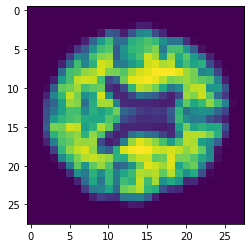

(92, 1, 28, 28)


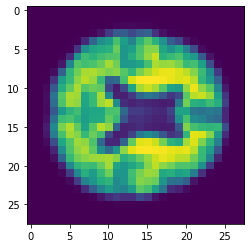

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


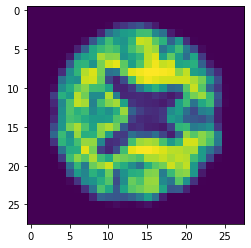

(92, 1, 28, 28)


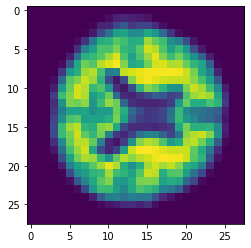

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


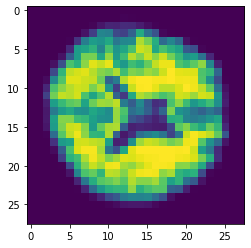

(92, 1, 28, 28)


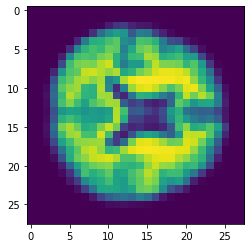

tensor(False, device='cuda:0')
target  1  prediction  0


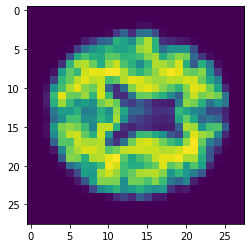

(92, 1, 28, 28)


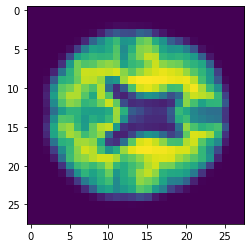

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


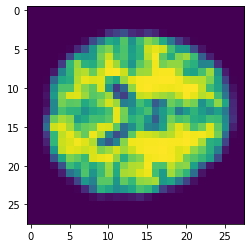

(92, 1, 28, 28)


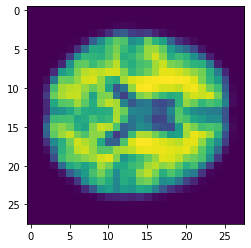

tensor(False, device='cuda:0')
target  1  prediction  0


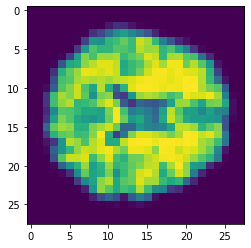

(92, 1, 28, 28)


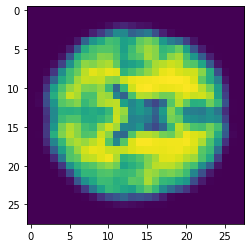

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


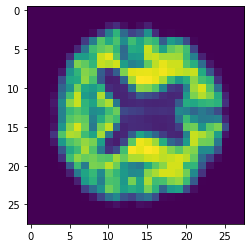

(92, 1, 28, 28)


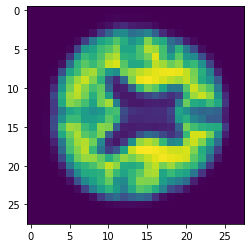

tensor(False, device='cuda:0')
target  0  prediction  1


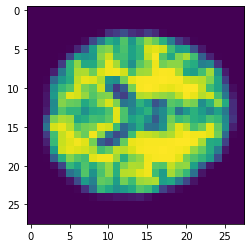

(92, 1, 28, 28)


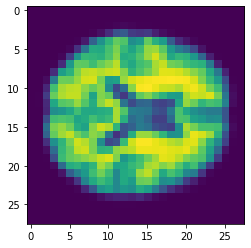

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


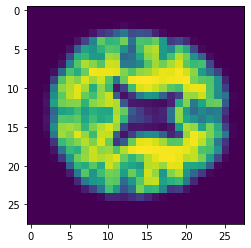

(92, 1, 28, 28)


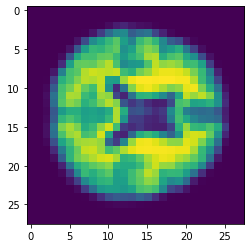

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  0  prediction  1


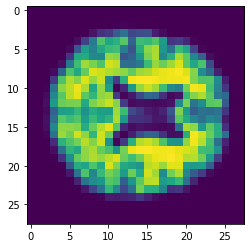

(92, 1, 28, 28)


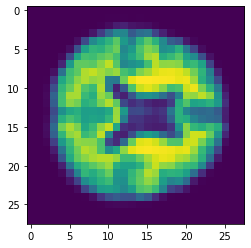

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
target  1  prediction  0


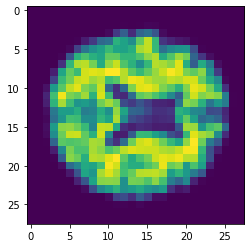

(92, 1, 28, 28)


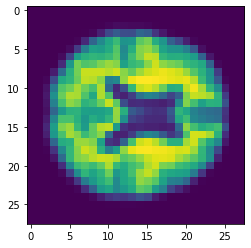

tensor(False, device='cuda:0')
target  0  prediction  1


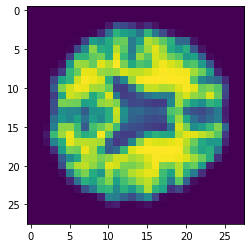

(92, 1, 28, 28)


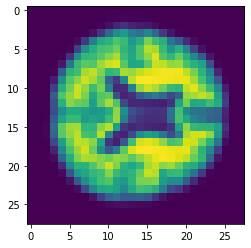

In [22]:
USE_CUDA=True
n_epochs = 1
start = 0
for epoch in range(start,start+n_epochs):
    model.eval()
    for batch_id, (data, target) in enumerate(test_loader,1):
#         target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        print('\t\t\t',batch_id,'/',lts,end='\r')
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()
#         pred_prob = model(data)
        pred_prob,dec = model(data)
#         print(pred_prob.shape)
        aa = pred_prob.max(dim=1)
#         print(aa.indices.shape)
#         print(target.shape)
        comp = aa.indices==target
#         print(comp)
        for idx,i in enumerate(comp):
            print(i)
            if not i:
                print('target ',target[idx].item(),' prediction ',aa.indices[idx].item())
                r = idx
#                 data = F.adaptive_avg_pool2d(data,mnist_shape)

                plt.imshow(data.cpu()[r,0])
                plt.show()
                print(dec.detach().cpu().numpy().shape)
                plt.imshow(dec.detach().cpu().numpy()[r,0])
                plt.show()
#             if idx ==100:
#                 break
#         break